# Ejercicio 6, Tarea 1
A una pequeña clínica llegan paciente para recibir tratamiento con una distribución de **Poisson** a una tasa de **cuatro por hora**.

Se proporciona atención médica a los pacientes uno en uno sobre la base de orden de llegada. El tiempo de servicio a cada cliente tiene una distribución **exponencial** con un tiempo medio de **12 minutos**.

Se proporciona una sala de espera con una capacidad de asientos tal que la probabilidad de que un paciente tenga que permanecer de **pie al llegar es de 0.10** ¿Cuál debería ser la capacidad de asientos?

## Especificaciones de la simulación
Se inicia la simulación asumiendo que no hay pacientes en el servicio y que el "servidor" está disponible (0 es disponible y 1 es ocupado) y con el reloj de la simulación en 0.0 minutos

El parámetro para generar la variable aleatoria de tiempo de servicio o atención está dada por una exponencial con media de 12minutos.

Por su parte, para generar los tiempos de llegada de los clientes con una distribución exponencial, también, se realizó el pequeño procedimiento a continuación para conocer la media que debía utilizarse:

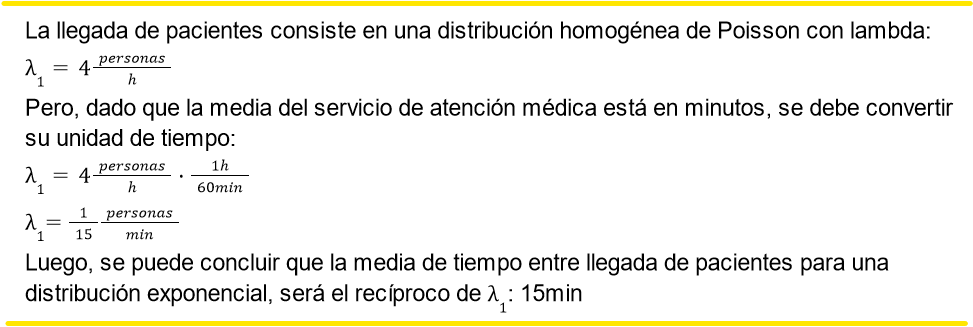


In [1]:
import numpy as np
from scipy.stats import t           # Para funciones relacionadas a T-student
import matplotlib.pyplot as plt     # Para graficar resultados

In [2]:
# Parámetros de simulación
p = {
    "mean_interarrival":15,
    "mean_service": 12
    }

In [3]:
class MM1_Clinica:

    def __init__(self, num_seats, num_delays_required):

        # Parámetros de entrada
        self.mean_interarrival = p["mean_interarrival"]
        self.mean_service = p["mean_service"]
        self.num_delays_required = num_delays_required #clientes que van a entrar a la simulación
        self.num_seats = num_seats # Sillas

        # Variables de estado
        self.server_status = 0 # 0 en idle y 1 en busy
        self.num_in_q = 0

        # Contadores estadísticos
        self.num_cust_delayed = 0
        self.num_waited_standing = 0

        # Reloj de simulación
        self.sim_time = 0.0

        # Lista de eventos
        self.time_next_event = [0,0,0] #Esta lista tiene 3 entradas, con el índice 0 no usado
        self.time_next_event[1] = self.sim_time + self.expon(self.mean_interarrival)
        self.time_next_event[2] = float('inf')

        # Otras variables
        self.num_events = 2

    def main(self):

        # Corre la simulación mientras se necesiten más retrasos
        while (self.num_cust_delayed < self.num_delays_required):

            # Determina cuál es el próximo evento
            self.timing()

            # Llama la función que le corresponde al evento ( tipo 1 es llegada y tipo 2 partida)
            if (self.next_event_type == 1):
                self.arrive()
            elif (self.next_event_type == 2):
                self.depart()
            else:
                break

        # Devuelve la probabilidad
        return self.num_waited_standing/self.num_delays_required



    def timing(self):

        # Variables necesarias para buscar en la lista de eventos el tiempo mínimo
        self.min_time_next_event = float('inf')
        self.next_event_type = 0

        # Determina el tipo de evento que ocurrirá
        for i in range(1, self.num_events + 1):
            if(self.time_next_event[i] < self.min_time_next_event):
                self.min_time_next_event = self.time_next_event[i]
                self.next_event_type = i

        # Verificar si todos de los eventos de la lista tienen valor infinito para detener la simulación
        if (self.next_event_type == 0) :
            raise Exception ("All entries in the event list have infinite values, so stop the simulation")

        # Si algun valor en la lista es finito, avanza el reloj de simulación
        self.sim_time = self.min_time_next_event



    def arrive(self):

        # Programar la próxima llegada
        self.time_next_event[1] = self.sim_time + self.expon(self.mean_interarrival)

        # Verificar si el servidor está ocupado
        if (self.server_status == 1): #busy
            self.num_waited_standing += 1 if self.num_in_q >= self.num_seats else 0
            self.num_in_q += 1
        else: # idle
            # Incrementa el numero de clientes retrasados y poner el servidor busy
            self.num_cust_delayed += 1
            self.server_status = 1

            # Agendar una partida
            self.time_next_event[2] = self.sim_time + self.expon(self.mean_service)



    def depart(self):

        # Verifica si la cola está vacía
        if (self.num_in_q == 0): # vacía
            self.server_status = 0
            self.time_next_event[2] = float('inf')
        else: # No vacía, disminuir un cliente de la cola
            self.num_in_q -= 1

            # Incrementa el número de clientes retrasados y agenda una partida
            self.num_cust_delayed += 1
            self.time_next_event[2] = self.sim_time + self.expon(self.mean_service)



    def report(self):
        print("-"*40)
        print("Single-server queueing system")
        print("Mean interarrival time: {:.3f} minutes".format(self.mean_interarrival))
        print("Mean service time: {:.3f} minutes".format(self.mean_service))
        print("Number of customers: {}".format(self.num_delays_required))
        print("Number of seats: {}".format(self.num_seats))
        print("-"*40)
        print("Time simulation ended: {:.3f} minutes".format(self.sim_time))
        print("Patients that waited standing: {}".format(self.num_waited_standing))
        print("Probability: {}".format(self.num_waited_standing/self.num_delays_required))
        print("-"*40)


    def expon(self, mean):

        return (-mean * np.log(np.random.uniform(0,1)))

In [4]:
def bar_diagram(x_data,y_data,y_err,graph_title):
    
    fig, ax = plt.subplots()

    # Agregar el gráfico de barras con barras de error
    ax.bar(x_data, y_data, yerr=y_err, capsize=5) #visualizar las primeras 30 simulaciones

    # Configurar las etiquetas de los ejes
    ax.set_xlabel("Número de asientos")
    ax.set_ylabel("Probabilidad")
    ax.set_title(graph_title)

    # Mostrar la rejilla
    ax.grid()

    # Mostrar el gráfico
    plt.show()

In [5]:
def simulate(patients,n,confidence_level,min_seats,max_seats):
    
    np.random.seed(1)

    # Variables de resultados
    num_seats = []
    probabilities = [] # Probabilidad media obtenida con un número dado de sillas
    err_prob = []

    # Variables de los intervalos de confianza
    a = 1 - confidence_level            # Se busca un nivel de confianza del 95%
    df = patients - 1       # Grados de libertad
    critical_value = t.ppf(1-a/2, df)

    # Simulación
    for s in range(min_seats, max_seats+1):
        num_seats.append(s)
        prob_sim = []

        # Obtener muestra de 100 simulaciones para cada número de sillas
        for i in range(1,n+1):
            sim = MM1_Clinica(s, patients)
            prob_sim.append(sim.main())
        
        # Obtener probabilidad media e intervalo de confianza del 95%
        average = np.mean(prob_sim) # Probabilidad media
        s = np.std(prob_sim)        # Desviación estandar
        err = critical_value * (s / np.sqrt(n))

        err_prob.append(err)
        probabilities.append(average)

    # Retornar resultados
    return {"num_seats":num_seats,
            "probabilities":probabilities,
            "err_prob":err_prob}

In [23]:
def probability_values(results_dictionary, min_seats, max_seats):
    print("REPORTE DE PROBABILIDADES\n")
    for i in range(min_seats-1,max_seats):
        seats = results_dictionary["num_seats"][i]
        media = results_dictionary["probabilities"][i]
        err = results_dictionary["err_prob"][i]
        print("Asientos: {} | Media: {:.3f} | Intervalo 95%: [{:.3f} , {:.3f}]".format(seats,media,media-err,media+err))

In [7]:
# SIMULACIÓN RÁPIDA DE PRUEBA:

# patients = 500
# n = 100 # CAMBIAR ESTO A 100 LUEGO
# min_seats = 1
# max_seats = 12
# confidence_level=0.95

# test_results=simulate(patients,n,confidence_level,min_seats,max_seats)

# bar_diagram(test_results["num_seats"],test_results["probabilities"],test_results["err_prob"], "Simulación rápida de prueba")

## Resultados
¿Cuál debería ser la capacidad de asientos para lograr que la que la **probabilidad** de que un paciente tenga que permanecer de pie al llegar sea de 0.10?

La propuesta para responder a la pregunta consiste en obtener la probabilidad (retornada con **main()**) de varias simulaciones con el mismo **num_delays_required** pero diferente **num_seats**, para poder comparar cómo la probabilidad cambia en función de capacidad de asientos en la sala.

Además, para poder obtener conclusiones más cercanas a la realidad, se consideró necesario simular **n** veces cada escenario de **s** asientos disponibles, para así comparar más bien las medias de probabilidad e incluir el intervalo de confianza (95%) en el análisis.


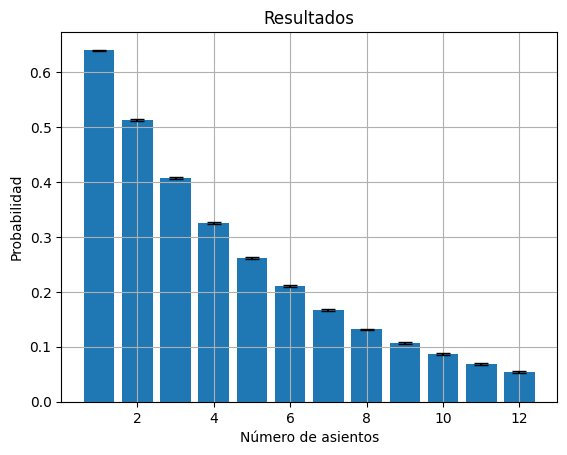

In [8]:
# SIMULACIÓN PARA ANÁLISIS (tiempo real aprox: 15min)

patients = 9600     # Pacientes que llegan a la clínica
n = 1000            # Número de simulaciones por cada capacidad de asientos
min_seats = 1
max_seats = 12
confidence_level = 0.95  # Calcular intervalo de confiaza T-Student del 95%

results=simulate(patients,n,confidence_level,min_seats,max_seats)

bar_diagram(results["num_seats"],results["probabilities"],results["err_prob"], "Resultados")

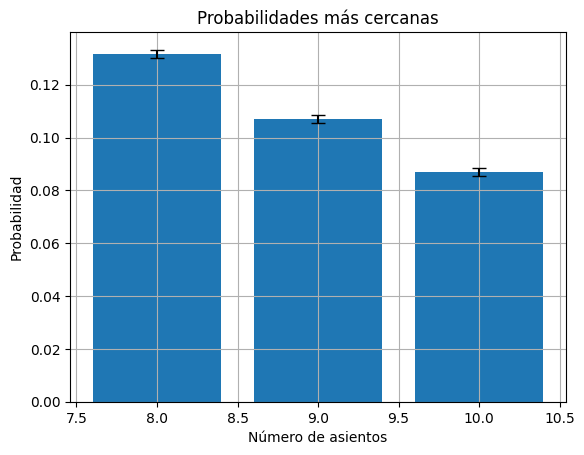

REPORTE DE PROBABILIDADES

Asientos: 8 | Media: 0.132 | Intervalo 95%: [0.130 , 0.133]
Asientos: 9 | Media: 0.107 | Intervalo 95%: [0.105 , 0.108]
Asientos: 10 | Media: 0.087 | Intervalo 95%: [0.086 , 0.088]


In [26]:
bar_diagram(results["num_seats"][7:10],results["probabilities"][7:10],results["err_prob"][7:10], "Probabilidades más cercanas")

# Mostrar media de probabilidades para 8, 9 y 10 asientos
probability_values(results,8,10)